## Exercise 2
### Energy Efficient Distributed Systems
#### SS 21
Kawczynski Christopher, Mazi Emeka, Bacca Lorenz

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
import time


from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


# Data Preparation
As a first step we are loading the data, filtering it down to one time series and selecting a period of 10 days.

In [11]:
data = pd.read_csv('datasets/traffic/traffic.csv')
data = data[(data.Junction == 1) & (data.DateTime >= '2017-01-01 00:00:00') & (data.DateTime < '2017-01-11 00:00:00')]
data = data.drop(['Junction', 'ID'], axis = 1)
data.rename(columns = {'DateTime': 'ds', 'Vehicles': 'y'}, inplace = True)

The data is then split into a train and test set with 7 training days and 3 test days. Since the data is given on an hourly basis this should equate to 168 training observations and 72 test obserations.

In [12]:
train, test = train_test_split(data, test_size=0.3,  shuffle = False)
print("Size of training set:", len(train))
print("Size of test set:", len(test))

Size of training set: 168
Size of test set: 72


# Prophet
As the first forecasting method we have choosen Facebook Prophet. This does not need any parameterization and so can simply be fit to the data at hand.

In [15]:
start = time.time()
m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=3*24, freq='H')
forecast = m.predict(future)
end = time.time()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


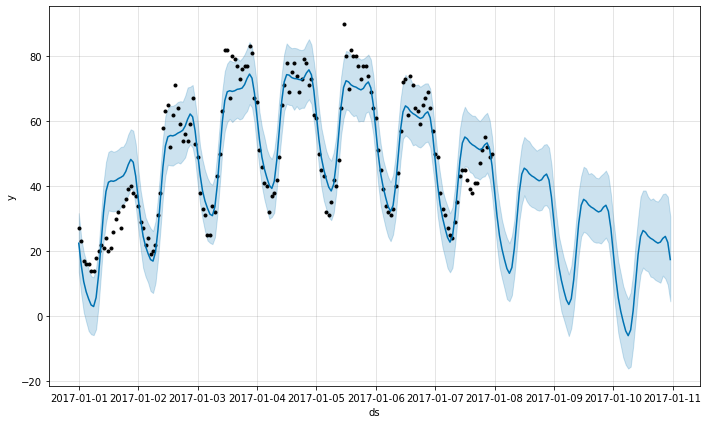

In [16]:
fig1 = m.plot(forecast)


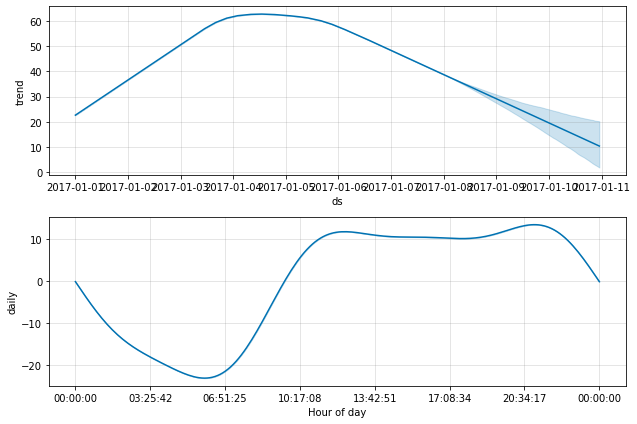

In [17]:
fig2 = m.plot_components(forecast)


In [18]:
test['ds'] = pd.to_datetime(test['ds'])
prediction = forecast[["ds", "yhat"]]
eval = pd.merge(prediction, test, how = "inner")


<ipython-input-18-8a401e3e3617>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [19]:
mae_prophet = mean_absolute_error(eval[['y']], eval[['yhat']])
mse_prophet = mean_squared_error(eval[['y']], eval[['yhat']])
mape_prophet = mean_absolute_percentage_error(eval[['y']], eval[['yhat']])

In [20]:
print("MAE of forecast for Prophet:", mae_prophet)
print("MSE of forecast for Prophet:", mse_prophet)
print("MAPE of forecast for Prophet:", mape_prophet)
print("Training and forecasting time:", end - start)

MAE of forecast for Prophet: 40.06241237613064
MSE of forecast for Prophet: 1980.2029703050587
MAPE of forecast for Prophet: 0.6027403049637409
Training and forecasting time: 3.5050668716430664


# ARIMA
As the second forecasting method we have chosen ARIMA. Since we need to choose parameters here we first have a look at the autocorrelation plot.

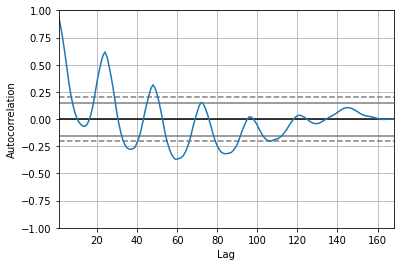

In [26]:
autocorrelation_plot(train.set_index('ds'))
pyplot.show()

As the series in non-stationary we choose the order of difference to be one. As for the lag value of the autocorelation it is very tricky to choose an appropriate value and we go for 50 in this case.


In [29]:
train.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [30]:
start = time.time()
model = ARIMA(train.set_index('ds'), order = (50,1,1))
fit = model.fit()
preds = fit.predict(1, 24*10, typ='levels')
end = time.time()

/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
preds = pd.DataFrame(preds).reset_index(level=0)
test['ds'] = pd.to_datetime(test['ds'])
eval = pd.merge(preds, test, how = "inner", left_on = 'index', right_on = 'ds')


<ipython-input-31-3d541296226e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [32]:
mae_arima = mean_absolute_error(eval[['y']], eval[['predicted_mean']])
mse_arima = mean_squared_error(eval[['y']], eval[['predicted_mean']])
mape_arima = mean_absolute_percentage_error(eval[['y']], eval[['predicted_mean']])

In [33]:
print("MAE of forecast for ARIMA:", mae_arima)
print("MSE of forecast for ARIMA:", mse_arima)
print("MAPE of forecast for ARIMA:", mape_arima)
print("Training and forecasting time:", end - start)

MAE of forecast for ARIMA: 37.11544819636715
MSE of forecast for ARIMA: 1971.3326201043008
MAPE of forecast for ARIMA: 0.5110781872501471
Training and forecasting time: 94.11431741714478


As can be seen by the metrics the forecasting accuracy of the ARIMA model is better then the performance of Facebook Prophet by all metrics. Prophet however is way faster in training and forecasting then ARIMA.

# Reducing training set
To see if the performance of the methods are related to the training data that is available we reduce the training set from 7 days to 3 days whilst keeping the test set at 3 days.

In [34]:
short_train = train[train.ds >= '2017-01-05 00:00:00']

## Prophet

In [35]:
m = Prophet()
m.fit(short_train)

future = m.make_future_dataframe(periods=3*24, freq='H')
forecast = m.predict(future)

test['ds'] = pd.to_datetime(test['ds'])
prediction = forecast[["ds", "yhat"]]
eval = pd.merge(prediction, test, how = "inner")

mae_short_prophet = mean_absolute_error(eval[['y']], eval[['yhat']])
mse_short_prophet = mean_squared_error(eval[['y']], eval[['yhat']])
mape_short_prophet = mean_absolute_percentage_error(eval[['y']], eval[['yhat']])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
<ipython-input-35-da4a790e04ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [36]:
print("MAPE of forecast for Prophet:", mape_prophet)
print("MAPE of forecast for Prophet with short training set:", mape_short_prophet)

MAPE of forecast for Prophet: 0.6027403049637409
MAPE of forecast for Prophet with short training set: 0.8571352850437431


As can be seen by the above metrics the performance of Prophet is decreasing a lot by reducing the training size.

## ARIMA

In [37]:
model = ARIMA(short_train.set_index('ds'), order = (50,1,1))
fit = model.fit()
preds = fit.predict(1, 24*10, typ='levels')

preds = pd.DataFrame(preds).reset_index(level=0)
test['ds'] = pd.to_datetime(test['ds'])
eval = pd.merge(preds, test, how = "inner", left_on = 'index', right_on = 'ds')

mae_short_arima = mean_absolute_error(eval[['y']], eval[['predicted_mean']])
mse_short_arima = mean_squared_error(eval[['y']], eval[['predicted_mean']])
mape_short_arima = mean_absolute_percentage_error(eval[['y']], eval[['predicted_mean']])

/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/lbacca/.local/lib/python3.8/site-packages/statsmodels/base/mode

In [38]:
print("MAPE of forecast for ARIMA:", mape_arima)
print("MAPE of forecast for ARIMA with short training set:", mape_short_arima)

MAPE of forecast for ARIMA: 0.5110781872501471
MAPE of forecast for ARIMA with short training set: 0.5573527388341665


As can be seen by the above metrics, also the performance of the ARIMA model is decreasing by reducing the training size, however not so much as for the Prophet model.